# Kopp21 et al 2021 Extract-Transform-Load
**Authorship:**
Adam Klie (last updated: *06/10/2023*)
***
**Description:**
Notebook to extract, transform, and load data from the Kopp21 et al (2021) dataset on JunD binding.
***

In [20]:
if 'autoreload' not in get_ipython().extension_manager.loaded:
    %load_ext autoreload 
%autoreload 2

In [1]:
import os
import sys

bin_dir = os.path.dirname(sys.executable)
os.environ["PATH"] += os.pathsep + bin_dir
from pybedtools import paths
paths._set_bedtools_path(bin_dir)
from pybedtools import BedTool

In [2]:
output = '/cellar/users/aklie/data/eugene/kopp21/'

# Downloads and command line data prep
Downloaded JunD peaks (ENCFF446WOD, conservative IDR thresholded peaks, narrowPeak format), and raw DNase-seq data (ENCFF546PJU, Stam. Lab, ENCODE; ENCFF059BEU Stam. Lab, ROADMAP, bam-format) for human embryonic stem cells (H1-hesc) from the encodeproject.org and the hg38 reference genome. Alignment indices were built with samtools. Blacklisted regions for hg38 were obtained from http://mitra.stanford.edu/kundaje/akundaje/release/blacklists/hg38-human/hg38.blacklist.bed.gz and removed using bedtools. The human genome was obtained from UCSC.

## Use `wget` to download data

In [ ]:
# Peaks from ENCODE
!wget https://www.encodeproject.org/files/ENCFF446WOD/@@download/ENCFF446WOD.bed.gz -O {output}/jund_peaks.narrowPeak.gz

# blacklisted regions to remove
!wget http://mitra.stanford.edu/kundaje/akundaje/release/blacklists/hg38-human/hg38.blacklist.bed.gz -O  {output}/hg38.blacklisted.bed.gz
!gunzip -f  {output}/hg38.blacklisted.bed.gz

# human genome sequence hg38
!wget http://hgdownload.cse.ucsc.edu/goldenPath/hg38/bigZips/hg38.fa.gz -O  {output}/hg38.fa.gz
!gunzip -f  {output}/hg38.fa.gz
!wget http://hgdownload.cse.ucsc.edu/goldenPath/hg38/bigZips/hg38.chrom.sizes -O {output}/hg38.chrom.sizes

## Create the peaks to use for prediction using `bedtools`

Merge the narrow peaks

In [ ]:
BedTool(os.path.join(output, 'jund_peaks.narrowPeak.gz')).sort().merge().saveas(
    os.path.join(output, 'jund_raw_peaks.bed'))

To create the region of interest (ROI) for defining positive and negative peaks, extend the "raw" peaks by 10000bp in both directions (https://bedtools.readthedocs.io/en/latest/content/tools/slop.html).
We also need to subtract away any parts of the ROI in blacklisted regions.

In [ ]:
BedTool(os.path.join(output, 'jund_raw_peaks.bed')).slop(b=10000, 
                                                               g=os.path.join(output, 'hg38.chrom.sizes')) \
 .sort().merge().subtract(os.path.join(output, 'hg38.blacklisted.bed'))\
.saveas(os.path.join(output, 'roi_jund_extended.bed'))

This [next command](https://github.com/BIMSBbioinfo/janggu/blob/5128419cf404d8f1904d46c627c0c7963356fff1/src/janggu/janggutrim.py) trims the starts and ends of the ROIs to make them divisible by the specified window size, in this case 200

In [ ]:
# You will need to have the janggu tool installed for this
!janggu-trim {output}/roi_jund_extended.bed {output}/trim_roi_jund_extended.bed -divby 200

Last we will split up the extended and trimmed ROIs into 200bp windows using `bedtools makewindows`

In [ ]:
# Make 200bp windows for the extended ROIs
BedTool(os.path.join(output, 'roi_jund_extended.bed')).makewindows(w=200, b=os.path.join(output, 'roi_jund_extended.bed'))\
    .saveas(os.path.join(output, 'jund_200bp.bed'))

# SeqData preparations
Next we need to use EUGENe to read in and prep this data.

In [12]:
# EUGENe imports
import eugene as eu
from eugene import preprocess as pp
from eugene import plot as pl
from eugene import settings
settings.dataset_dir = '/cellar/users/aklie/data/eugene/revision/kopp21'

# EUGENe packages
import seqdata as sd
import seqpro as sp

# Print versions
print(f"Python version: {sys.version}")
print(f"Eugene version: {eu.__version__}")
print(f"SeqData version: {sd.__version__}")
print(f"SeqPro version: {sp.__version__}")

Python version: 3.9.16 | packaged by conda-forge | (main, Feb  1 2023, 21:39:03) 
[GCC 11.3.0]
Eugene version: 0.0.8
SeqData version: 0.0.1
SeqPro version: None


## Load in the SeqData 

In [ ]:
# Definethe input files
bam_file = os.path.join(eu.settings.dataset_dir,"dnase_stam_encode.bam")
target_file = os.path.join(eu.settings.dataset_dir,"jund_raw_peaks.bed")
roi_file = os.path.join(settings.dataset_dir, "trim_roi_jund_extended.bed")
bed_file = os.path.join(settings.dataset_dir, "jund_200bp.bed")
refgenome = os.path.join(settings.dataset_dir,"hg38.fa")

In [4]:
# Load in from files into SeqData
sdata = sd.read_bam(
    seq_name='seq',
    cov_name='cov',
    out=os.path.join(settings.dataset_dir, "kopp21.zarr"),
    fasta=refgenome,
    bams=[bam_file],
    samples=['stam'],
    bed=bed_file,
    batch_size=4096,
    fixed_length=500,
    threads_per_job=4,
    alphabet='DNA',
    overwrite=True
)
#sdata = sd.open_zarr(os.path.join(settings.dataset_dir, 'kopp21.zarr'))
sdata

## Define targets

In [6]:
# Read in the targets for 
targets_df = sd.read_bedlike(os.path.join(settings.dataset_dir, 'jund_raw_peaks.bed'))
targets_df.head()

,chrom,chromStart,chromEnd
0,chr1,1000795,1001019
1,chr1,1024682,1024992
2,chr1,1032948,1033258
3,chr1,1064215,1064525
4,chr1,1291838,1292148


In [7]:
# Mark the sequences for classification
_sdata = sdata.copy()
_sdata['chromStart'] += 150
_sdata['chromEnd'] -= 150
sdata['target'] = sd.mark_sequences_for_classification(_sdata, targets_df, 'binary')

In [14]:
# One-hot encode the sequences
pp.ohe_seqs_sdata(sdata)

In [21]:
# Split into train and test sets
pp.train_test_split_sdata(
    sdata, 
    train_key="train_test",
    chroms = ["chr3"]
)

In [25]:
# Split into training and test sets
sdata_train = sdata.sel(_sequence=(sdata["train_test"]==True).compute())
sdata_test = sdata.sel(_sequence=(sdata["train_test"]==False).compute())

In [29]:
# Split the training sequences into train and validation sets
pp.train_test_chrom_split(
    sdata_train,
    test_chroms=["chr2"]
)

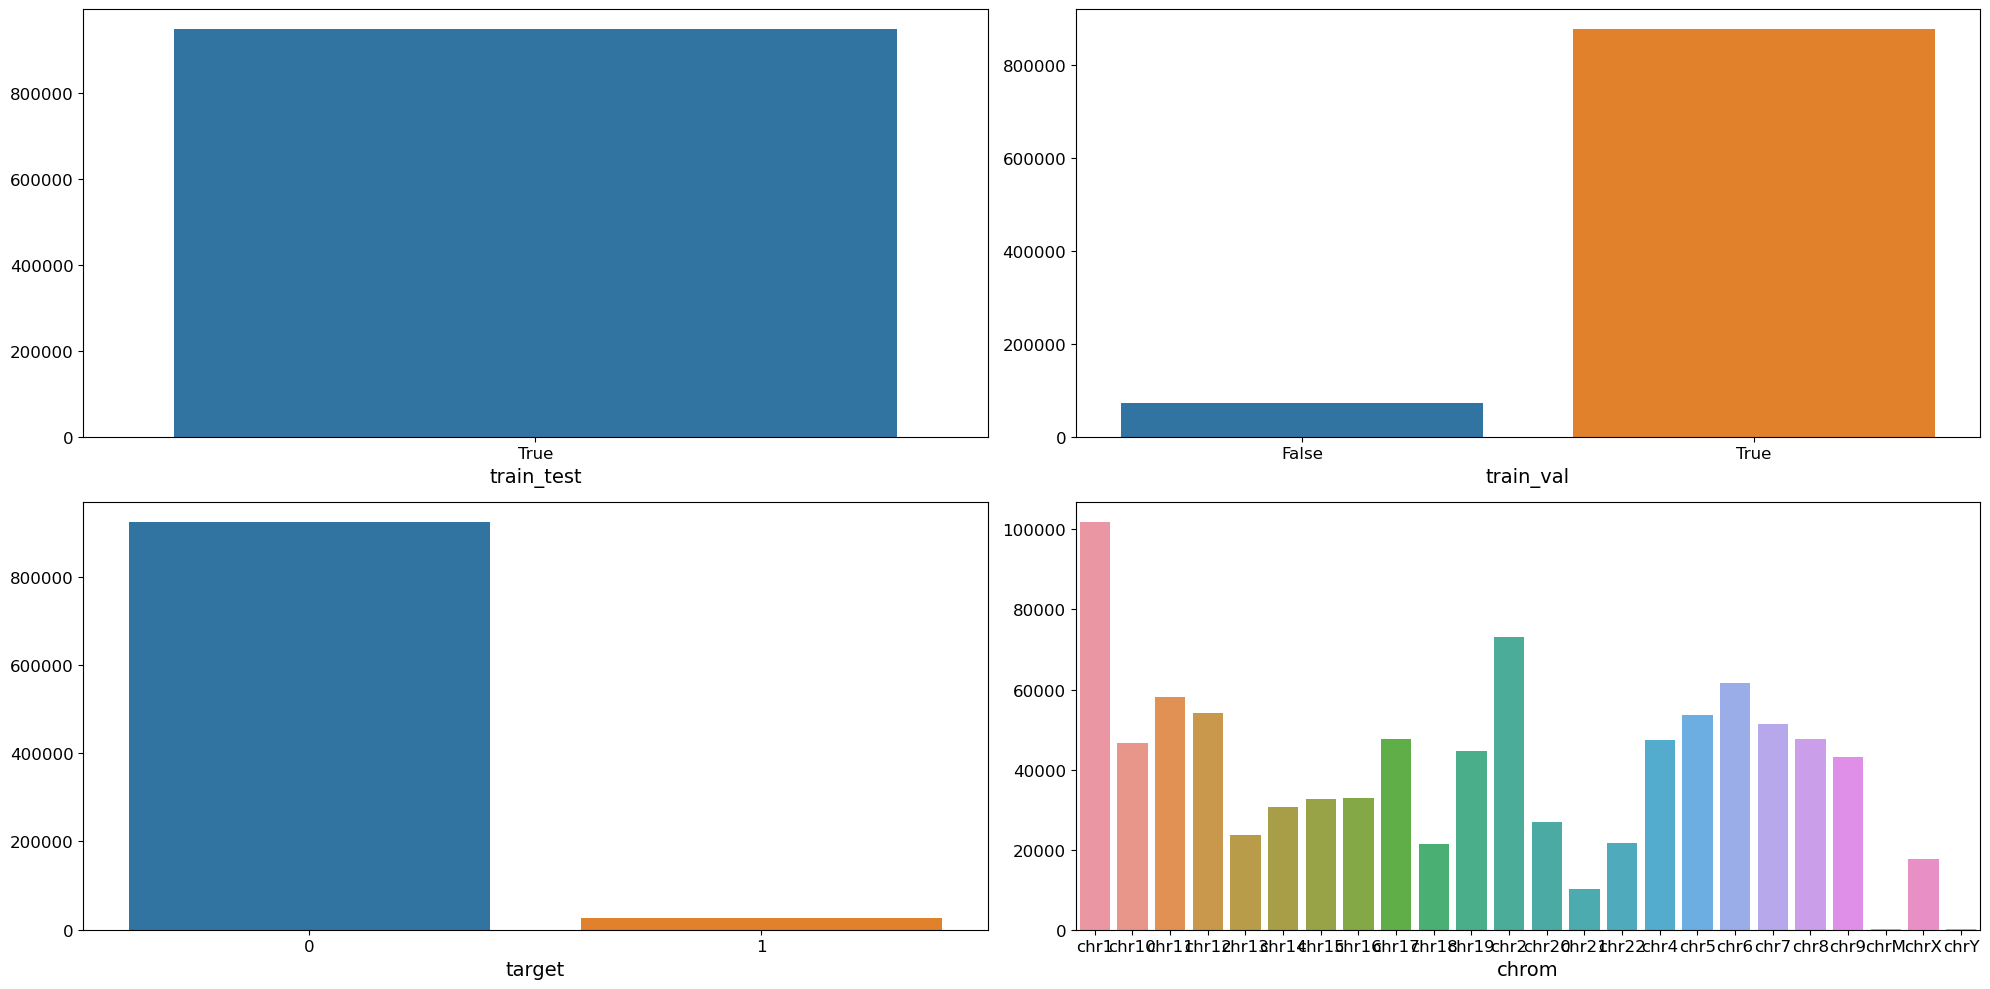

In [37]:
# Plot the distribution of the training and validation setsm chromosomes and targets
pl.countplot(
    sdata_train,
    keys=["train_test", "train_val", "target", "chrom"],
)

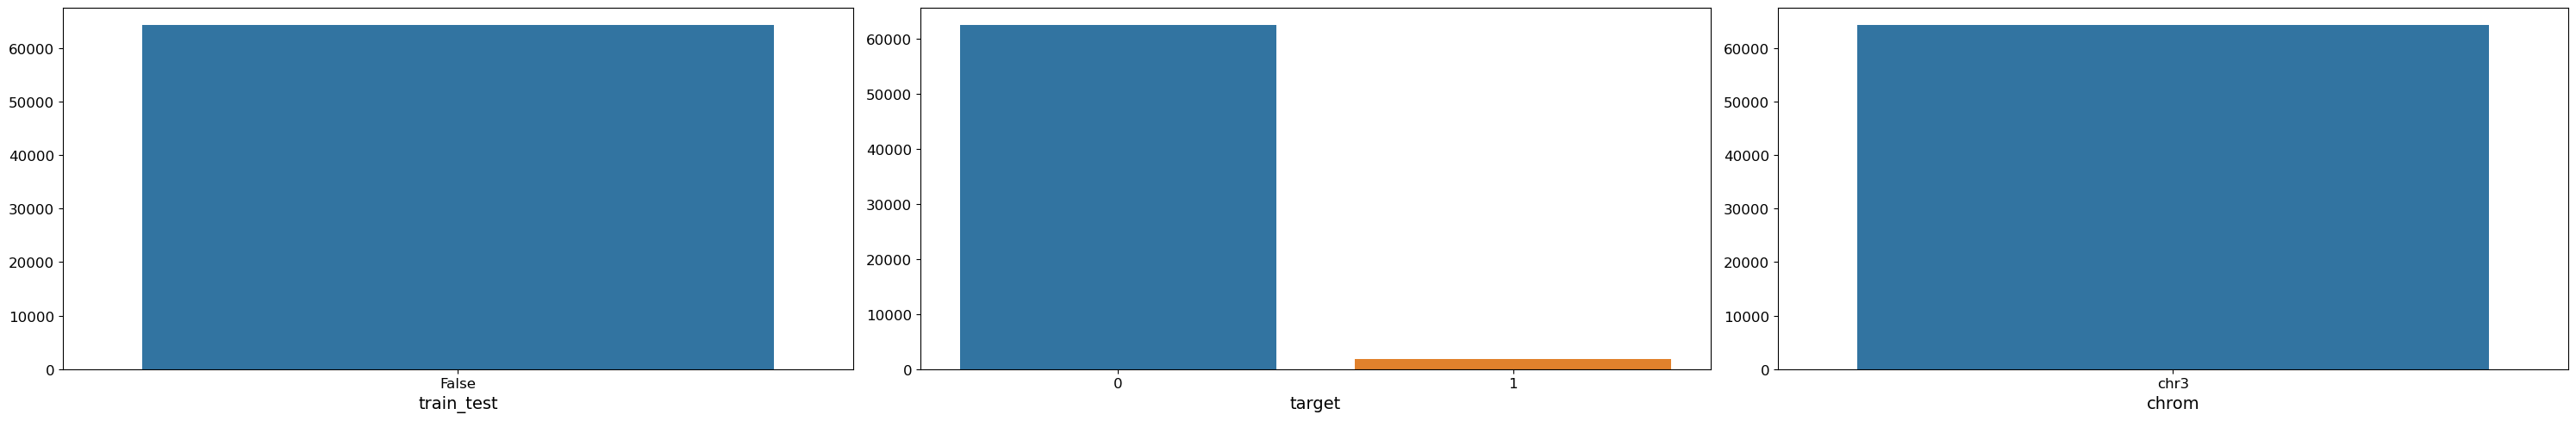

In [38]:
# Plot the distribution of the test set chromosomes and targets
pl.countplot(
    sdata_test,
    keys=["train_test", "target", "chrom"],
)

In [40]:
# Save train and test sets
sd.to_zarr(sdata_train, os.path.join(settings.dataset_dir, 'kopp21_train.zarr'), mode="w", load_first=True)
sd.to_zarr(sdata_test, os.path.join(settings.dataset_dir, 'kopp21_test.zarr'), mode="w", load_first=True)

# DONE!

---

# Scratch

## Test to make sure the save was successful

In [43]:
settings.dataset_dir = "/cellar/users/aklie/data/eugene/revision/kopp21"
for zarr in ["kopp21_train.zarr", "kopp21_test.zarr"]:
    print(zarr)
    sdata = sd.open_zarr(os.path.join(settings.dataset_dir, zarr))
    print(sdata.dims["_sequence"])
    if "train_val" in sdata.data_vars:
        print(np.unique(sdata["train_val"].values, return_counts=True))
    else:
        print("No train_val column found")
    print(np.unique(sdata["target"].values, return_counts=True))
    print(np.unique(sdata["chrom"].values, return_counts=True))

kopp21_train.zarr
948771
(array([False,  True]), array([ 73224, 875547]))
(array([0, 1], dtype=uint8), array([922682,  26089]))
(array(['chr1', 'chr10', 'chr11', 'chr12', 'chr13', 'chr14', 'chr15',
       'chr16', 'chr17', 'chr18', 'chr19', 'chr2', 'chr20', 'chr21',
       'chr22', 'chr4', 'chr5', 'chr6', 'chr7', 'chr8', 'chr9', 'chrM',
       'chrX', 'chrY'], dtype=object), array([101752,  46642,  58193,  54162,  23593,  30690,  32528,  33013,
        47697,  21394,  44522,  73224,  26908,  10060,  21565,  47435,
        53688,  61670,  51281,  47548,  43141,     82,  17681,    302]))
kopp21_test.zarr
64309
No train_val column found
(array([0, 1], dtype=uint8), array([62548,  1761]))
(array(['chr3'], dtype=object), array([64309]))
